In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import pykgraph
#from PIL import Image
import matplotlib.pyplot as plt
#from IPython.display import Image, display
import matplotlib.image as mpimg
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Read the data and shape them accordingly
vec = np.fromfile('../data/oxford_105k/imgdesc105k.dat', dtype=np.float32)
points = vec.reshape(-1, 128)
print(points.shape)

names = pd.read_csv('../data/oxford_105k/imagenames105k.txt', header=None)

index = pykgraph.KGraph(points, 'euclidean')  # another option is 'angular'
index.build(reverse=-1)                        #
index.save("index_file")

(104933, 128)


(128,)
The neighbours of 1100 are: [   739   2323   1292 102350    882]
['christ_church_000844']
['christ_church_000090']
['magdalen_001151']
['cornmarket_000136']
['0019/wedding_003040']
['christ_church_000339']


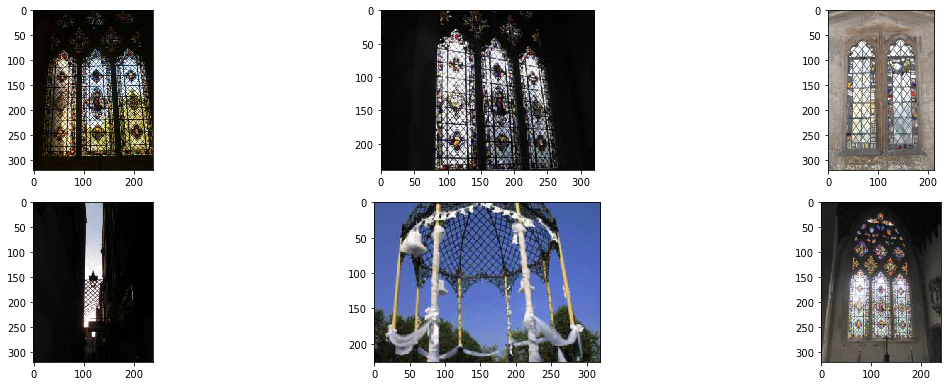

In [3]:
index.load('index_file')

query = points[1100, :]

print(query.shape)
knn = index.search(query.reshape(-1, 128), K=6)

print("The neighbours of", knn[0][0], "are:",  knn[0][1:])

images = []
for r in knn[0]:
    print(names.values[r])
    img_path = '../data/oxford_105k/oxc-complete/' + names.values[r][0] + '.jpg'
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(20,10))
columns = 3
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)

    

In [4]:
points.shape

(104933, 128)

In [17]:
import sys
import time
from numpy import random

N = points.shape[0]
Q = 1000
D = points.shape[1]
TYPE = 'f'
USE_SKLEARN = True

def eval (gold, result):
    assert gold.shape == result.shape
    N = gold.shape[0]
    K = gold.shape[1]
    total = 0
    for i in range(N):
        total += len(set(gold[i]).intersection(result[i]))
    return 1.0 * total / (N * K)

def eval2(gold, result):
    assert gold.shape == result.shape
    N = gold.shape[0]
    K = gold.shape[1]
    total = 0
    for i in range(N):
        #if len(set(gold[i]).intersection(result[i][0])) > 0: 
        if gold[i][0] in result[i]:
            total += 1 
    return 1.0 * total / N

dataset = points
np.random.seed(1234)
idx = np.random.randint(0, N, Q)
query = dataset[idx]

In [18]:
query.shape

(1000, 128)

In [27]:
index = pykgraph.KGraph(dataset, "euclidean")
K=1000
#index.build(reverse=-1)
#index.save("index_file");
# load with index.load("index_file");

gold = None
print("Generating gold standard...")
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=K, algorithm='brute').fit(dataset)
start = time.time()
distances, gold = nbrs.kneighbors(query)
print("Time:", time.time() - start)

print("Searching with brute force...")
start = time.time()
result = index.search(query, K=K)   # this uses all CPU threads, set prune=1 to make index smaller (no accuracy loss)
bf_time = time.time() - start
print("Time:", bf_time)
if gold is None:
    gold = result
else:
    print("Recall:", eval(gold, result))

print("Searching with BLAS...")
start = time.time()
result = index.search(query, K=K, blas=True)
blas_time = time.time() - start
print("Time:", blas_time)
print("Recall:", eval(gold, result))

print("Building index...")
start = time.time()
index.build(reverse=-1)
build_index_time = time.time() - start
print("Building index time:", build_index_time)

print("Searching with index...")
start = time.time()
result = index.search(query, K=K)
index_time = time.time() - start
print("Search Time for 1000 datapoints with K=5:", index_time)
#print("Recall:", eval(gold, result))

print("blas startup:", bf_time / blas_time)
print("index startup:", bf_time / index_time)

Generating gold standard...
Time: 1.88569521904
Searching with brute force...
Time: 4.91066884995
Recall: 0.999992
Searching with BLAS...
Time: 4.93649506569
Recall: 0.999992
Building index...
Building index time: 20.2925651073
Searching with index...
Search Time for 1000 datapoints with K=5: 1.68124294281
blas startup: 0.994768309215
index startup: 2.92085618616


In [28]:
K=5
index.load('index_file')
print("Searching 1000 datapoints with index using K=5")
start = time.time() 
result = index.search(query, K=K)
index_time = time.time() - start
print("Time:", index_time)
#print("Recall:", eval(gold[:, 1:K], result[:, 1:]))

Searching 1000 datapoints with index using K=5
Time: 0.254259109497


In [20]:
index.load('index_file')
recalls=[]
kappas = [2, 5, 10, 20, 30, 50, 100, 250, 500, 1000]
for k in kappas:
    result = index.search(query, K=k)
    recalls.append(eval(gold[:, 1:k], result[:, 1:]))


In [21]:
recalls

[0.959,
 0.98625,
 0.9895555555555555,
 0.992,
 0.991551724137931,
 0.9901428571428571,
 0.9875555555555555,
 0.9877911646586346,
 0.9883807615230461,
 0.9891161161161162]

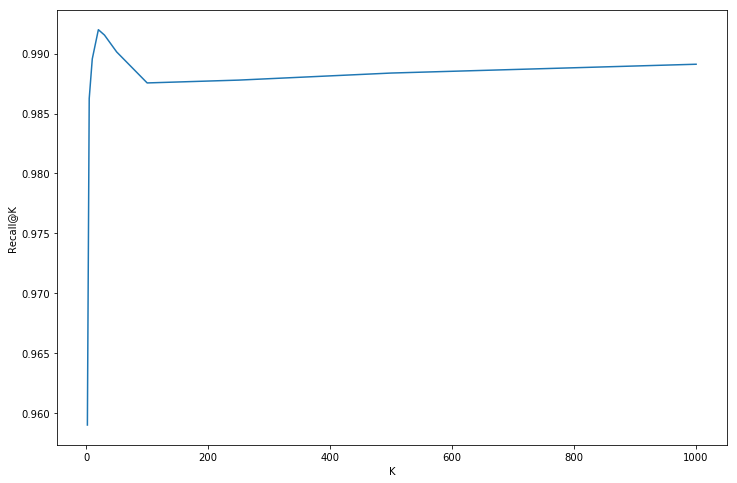

In [22]:
plt.figure(figsize=(12,8))
plt.xlabel("K")
plt.ylabel("Recall@K")
plt.plot(kappas, recalls)

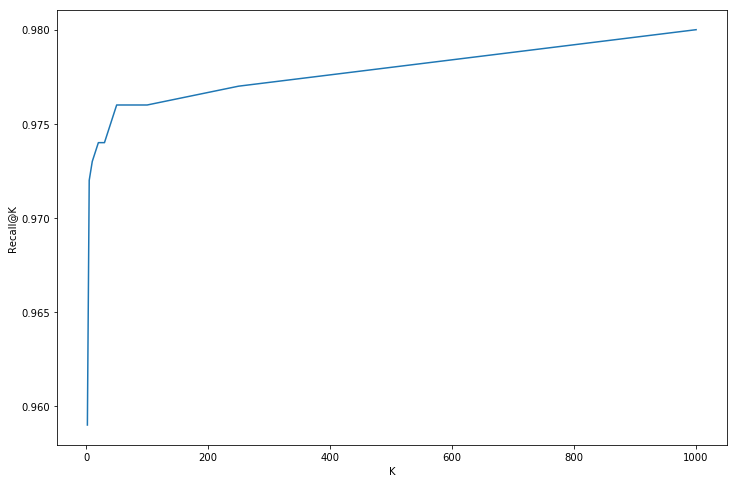

In [23]:
index.load('index_file')
recalls2=[]
kappas = [2, 5, 10, 20, 30, 50, 100, 250, 500, 1000]
for k in kappas:
    result = index.search(query, K=k)
    recalls2.append(eval2(gold[:, 1:k], result[:, 1:]))

plt.figure(figsize=(12,8))
plt.xlabel("K")
plt.ylabel("Recall@K")
plt.plot(kappas, recalls2)

In [24]:
recalls2


[0.959, 0.972, 0.973, 0.974, 0.974, 0.976, 0.976, 0.977, 0.978, 0.98]